Importing modules

In [46]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mode
from pathlib import Path
from os.path import join as pjoin

import chiCa
from chiCa.visualization_utils import separate_axes
from spks.sync import load_ni_sync_data,interp1d
from spks.event_aligned import compute_firing_rate
from spks.clusters import Clusters

from utils import *
from viz import *


%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading nidaq and behavior data

In [94]:
animal = 'GRB006'
session = '20240724_144439'
sessionpath = Path(f'/home/data/{animal}/{session}/')
sync_port = 0 # this is where the SMA of the probe is connected

(nionsets,nioffsets),(nisync,nimeta),(apsyncdata) = load_ni_sync_data(sessionpath=sessionpath)
aponsets = apsyncdata[0]['file0_sync_onsets'][6] # this should be the same for you, its where the sync is on the probe

corrected_onsets = {}
corrected_offsets = {} # This is a dictionary with the digital events that were connected to the breakout box.
for k in nionsets.keys():
    corrected_onsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nionsets[k]).astype('uint64')
    corrected_offsets[k] = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(nioffsets[k]).astype('uint64')
del k

# if you need analog channels those are in "nisync"
nitime = interp1d(nionsets[sync_port],aponsets,fill_value='extrapolate')(np.arange(len(nisync)))

# everything is in samples, use this sampling rate
srate = apsyncdata[0]['sampling_rate']  
t = nitime/srate
frame_rate = mode(1/(np.diff(corrected_onsets[1])/srate)) #corrected_onsets[1] are the frame samples, [2] are the trial start samples
analog_signal = nisync[:, 0] # analog stim signal

# storing digital events in seconds
trial_starts = corrected_onsets[2]/srate
left_port_entries = corrected_onsets[3]/srate
left_port_exits = corrected_offsets[3]/srate
center_port_entries = corrected_onsets[4]/srate
center_port_exits = corrected_offsets[4]/srate
right_port_entries = corrected_onsets[5]/srate
right_port_exits = corrected_offsets[5]/srate

# for simplicity later
port_events = {
    "center_port": {
        "entries": center_port_entries,
        "exits": center_port_exits
    },
    "left_port": {
        "entries": left_port_entries,
        "exits": left_port_exits
    },
    "right_port": {
        "entries": right_port_entries,
        "exits": right_port_exits
    }
}

behavior_data = chiCa.load_trialdata(pjoin(sessionpath, f'chipmunk/{animal}_{session}_chipmunk_DemonstratorAudiTask.mat'))

# get trialized timestamps for task events
trial_ts = get_trial_ts(trial_starts, detect_stim_events(t, srate, analog_signal, amp_threshold=5000), behavior_data, port_events)
trial_ts.insert(trial_ts.shape[1], 'response', trial_ts.apply(get_response_ts, axis=1))
trial_ts.insert(trial_ts.shape[1], 'stationary_stims', trial_ts.apply(get_stationary_stims, axis=1))
trial_ts.insert(trial_ts.shape[1], 'movement_stims', trial_ts.apply(get_movement_stims, axis=1))

/opt/conda/envs/spks-gabriel/lib/python3.12/site-packages/chiCa/chipmunk_analysis_tools.py:321: UserWarning: Found multisensory trials, assumed synchronous condition
  warnings.warn('Found multisensory trials, assumed synchronous condition')


In [95]:
trial_ts

,trial_rate,detected_events,trial_start,stim_ts,first_stim_ts,trial_outcome,center_port_entries,center_port_exits,left_port_entries,left_port_exits,right_port_entries,right_port_exits,response,stationary_stims,movement_stims
0,10,1,32.686400,[41.547104941866664],41.547105,-1,"[41.517066666666665, 41.656]","[41.61286666666667, 41.94566666666667]",[],[],[],[],NaN,[41.547104941866664],[]
1,20,9,43.677833,"[45.706596, 45.786692, 45.86658, 45.90658, 45....",45.706596,-1,"[45.6184, 47.5905]","[46.190266666666666, 47.676766666666666]",[],[],[],[],NaN,"[45.706596, 45.786692, 45.86658, 45.90658, 45....",[]
2,6,6,48.251800,"[49.48232266666666, 49.72219466666667, 49.7621...",49.482323,0,[49.42583333333334],[50.15056666666667],[],[],[50.98206666666667],[],50.982067,"[49.48232266666666, 49.72219466666667, 49.7621...","[50.28219466666667, 50.32224266666667]"
3,8,8,52.034733,"[53.335154669333335, 53.45513733333334, 53.735...",53.335155,1,[53.2484],[54.0963],[54.90473333333333],[],[],[52.61136666666667],54.904733,"[53.335154669333335, 53.45513733333334]","[54.17507333333333, 54.255169333333335]"
4,12,12,54.979167,"[58.124064, 58.164112, 58.204, 58.324048, 58.3...",58.124064,1,[58.0771],[58.643966666666664],"[59.180033333333334, 59.1801]","[56.55963333333333, 59.18006666666667]",[],[],59.180033,"[58.124064, 58.164112, 58.204, 58.324048, 58.3...","[58.644016, 58.684064, 58.763952, 58.883936000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,12,12,3253.245967,"[3258.91412, 3259.034216, 3259.154152, 3259.19...",3258.914120,1,[3258.8627666666666],[3259.504033333333],[3261.1873],[],[],[],3261.187300,"[3258.91412, 3259.034216, 3259.154152, 3259.1942]","[3259.5141227187632, 3259.6340606377703, 3259...."
521,10,5,3261.263967,"[3271.7581981962667, 3271.8381315317333, 3271....",3271.758198,-1,[3271.6604],[3272.2272],[],[3263.1098333333334],[],[],NaN,"[3271.7581981962667, 3271.8381315317333, 3271....",[]
522,6,6,3274.280033,"[3275.2671078976, 3275.347153333333, 3275.7071...",3275.267108,1,[3275.2293],[3275.9220666666665],[3276.6170666666667],[],[],[],3276.617067,"[3275.2671078976, 3275.347153333333]","[3275.9470413333333, 3275.9870413333333]"
523,12,12,3276.693667,"[3299.4993001509333, 3299.539346816, 3299.5793...",3299.499300,1,[3299.4443],[3300.0310666666664],[3300.981533333333],[3278.9217],[],[],3300.981533,"[3299.4993001509333, 3299.539346816, 3299.5793...","[3300.0592814842666, 3300.2593068165334, 3300...."


Inter stimulus event interval histogram

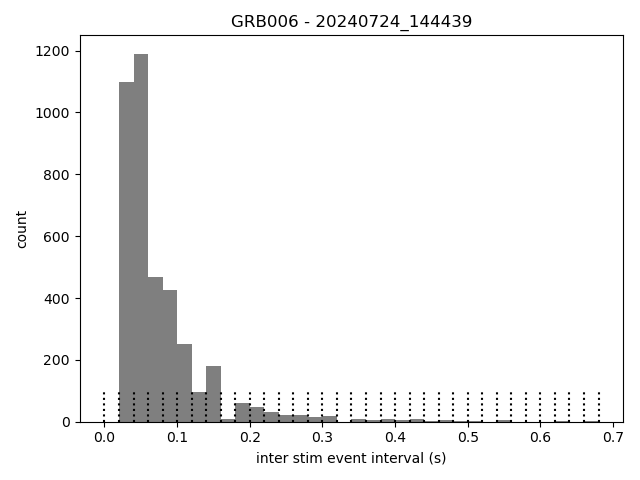

In [3]:
plt.figure()
plt.hist(np.diff(np.hstack(trial_ts.stim_ts)), np.arange(0, 0.7, 0.02), color='k', alpha = 0.5)
plt.vlines(np.arange(0, 0.7, 0.02), 0, 100, color='k', alpha = 1, linestyles='dotted')
plt.xlabel('inter stim event interval (s)')
plt.ylabel('count')
plt.title(f'{animal} - {session}')
plt.tight_layout()

Loading and filtering KS results

In [4]:
kilosort_path = Path(f'/home/data/{animal}/{session}/kilosort2.5/imec0/')
sc = np.load(pjoin(kilosort_path, 'spike_clusters.npy')) #KS clusters
ss = np.load(pjoin(kilosort_path, 'spike_times.npy')) #KS spikes (in samples)
st = ss/srate #conversion from spike samples to spike times

clu = Clusters(folder = kilosort_path, get_waveforms=False, get_metrics=True, load_template_features=True)

good_unit_ids, n_units = get_good_units(clusters_obj = clu, spike_clusters = sc)


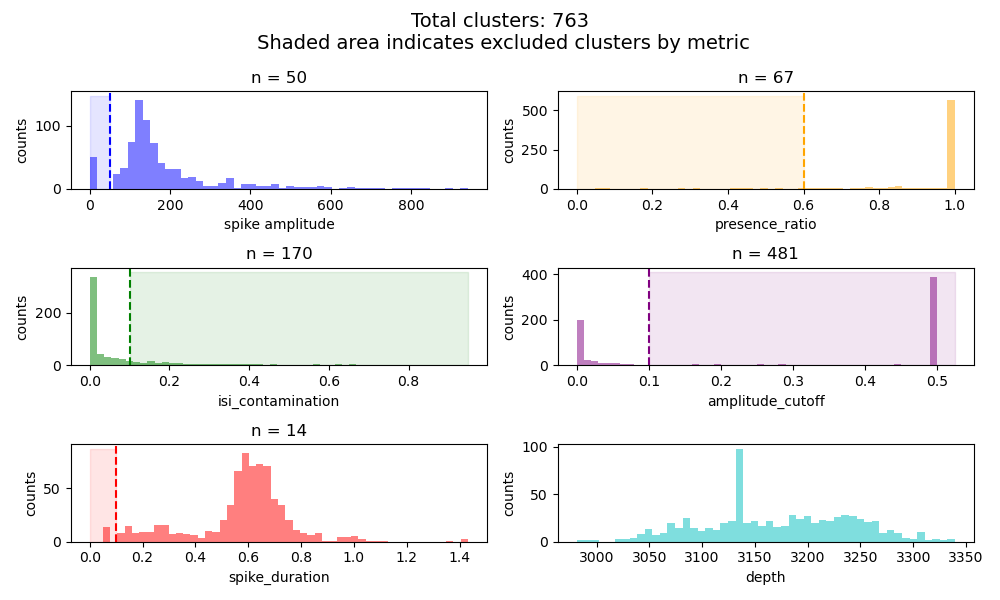

In [5]:
plot_cluster_info_histograms(clu)

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2591361/2093300346.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Depth from probe tip ($\mu$m)')


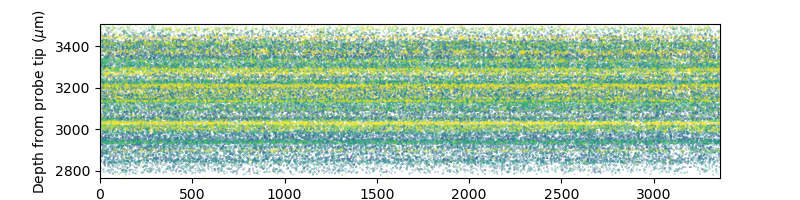

In [6]:
# there are multiple ways to plot the drift raster one is using the Clusters object.
plt.figure(figsize = [8,2])

clu.plot_drift_map(clim = [0,2000])

plt.ylabel('Depth from probe tip ($\mu$m)')
plt.xlabel('Time (min)');

Static population PSTH plotting

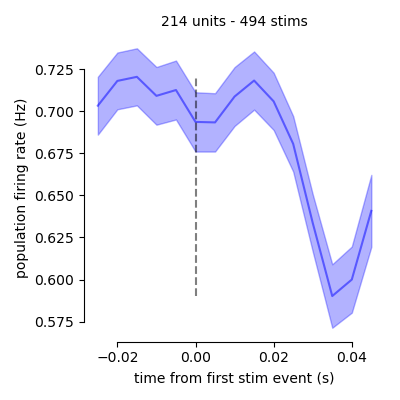

In [435]:
binwidth_ms = 5
window_ms = 20
tpre = 0.03
tpost = 0.06

# population_timestamps = st[good_unit_ids]
# single_unit_timestamps = get_cluster_spike_times(spike_times = st, spike_clusters = sc, good_unit_ids = good_unit_ids)

# psth, unit_fr = get_population_firing_rate(event_times = np.hstack(trial_ts.first_stim_ts),
#                                   spike_times = single_unit_timestamps,
#                                   tpre = tpre,
#                                   tpost = tpost,
#                                   binwidth_ms = binwidth_ms, 
#                                   window_ms = window_ms)
# n_stims = len(psth)

plt.figure(figsize=(4, 4))
plot_psth(mean_sem_func = compute_mean_sem(norm_fr),
          pre_seconds = tpre, 
          post_seconds = tpost, 
          binwidth_ms = binwidth_ms, 
          window_ms = window_ms, 
          xlabel = 'time from first stim event (s)', 
          ylabel = 'population firing rate (Hz)', 
          fig_title = f"{n_units} units - {n_stims} stims")
separate_axes(plt.gca())

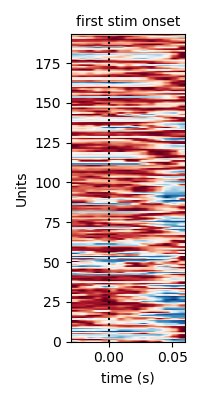

In [485]:

# norm_fr = np.array([unit/unit.max() for unit in unit_fr if not unit.all() == 0])
fixed_unit_fr = np.array([unit for unit in unit_fr if not unit.all() == 0])

# print(norm_fr.shape)
# fig, axs = plt.subplots(1,2,figsize=(8,4))
# iunit=150
# # plt.plot()
# axs[0].plot(np.mean(norm_fr, axis = 0), label='norm', color='b')
# # axs[0].plot(norm_fr[iunit], label='unit example', color='k')
# # axs[1].plot(fixed_unit_fr[iunit], label='unit example', color='k')
# axs[1].plot(np.mean(unit_fr, axis = 0), label='raw', color='r')
# fig.legend()
plt.figure(figsize=(2,4))
# for unit in norm_fr:
#     plt.plot(moving_average(unit, int(window_ms / binwidth_ms)))
# plt.ylim([0, 2])
# # np.mean(norm_fr, axis = 0)
# plt.imshow(norm_fr, aspect='auto')
# plt.figure(figsize=(2,6))
plt.imshow(norm_fr, aspect='auto', extent=[-tpre,tpost,0,len(norm_fr)],cmap = 'RdBu_r')
plt.ylabel('Units')
plt.xlabel('time (s)')
plt.title('first stim onset', fontsize=10)
plt.vlines(0, 0, len(norm_fr), linestyles='dotted', color='k')
plt.tight_layout()

In [367]:
unit_fr[39]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.10121457,
       0.10121457, 0.10121457, 0.10121457, 0.10121457, 0.10121457])

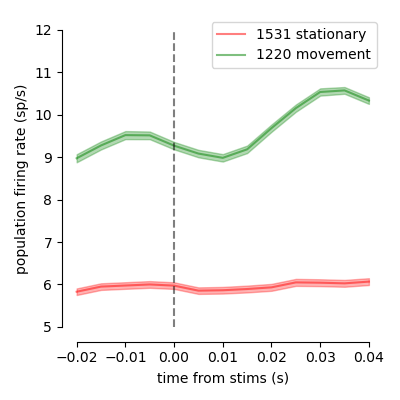

In [487]:
binwidth_ms = 5
window_ms = 20
tpre = 0.025
tpost = 0.055

# stationary_psth, _ = get_population_firing_rate(event_times = np.hstack(trial_ts[trial_ts.trial_outcome.isin([0,1])].stationary_stims),
#                                   spike_times = single_unit_timestamps,
#                                   tpre = tpre,
#                                   tpost = tpost,
#                                   binwidth_ms = binwidth_ms,
#                                   window_ms = window_ms)

# movement_psth, _ = get_population_firing_rate(event_times = np.hstack(trial_ts[trial_ts.trial_outcome.isin([0,1])].movement_stims),
#                                   spike_times = single_unit_timestamps,
#                                   tpre = tpre,
#                                   tpost = tpost,
#                                   binwidth_ms = binwidth_ms,
#                                   window_ms = window_ms)

plt.figure(figsize=(4,4))
plot_psth(compute_mean_sem(stationary_psth), tpre, tpost, binwidth_ms, window_ms, 'time from stims (s)', 'population firing rate (sp/s)', color = 'r', data_label = f'{len(stationary_psth)} stationary', vline=False)
plot_psth(compute_mean_sem(movement_psth), tpre, tpost, binwidth_ms, window_ms, 'time from stims (s)', 'population firing rate (sp/s)', color = 'g', data_label = f'{len(movement_psth)} movement', vline=False)
plt.yticks(np.arange(5,13,1))
# plt.xticks(np.arange(-0.03, 0.06, 0.01))
separate_axes(plt.gca())
plt.vlines(0, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], color='k', linestyles='dashed', alpha=0.5)

In [114]:
from utils import moving_average

# moving_average(stationary_psth, 50)

stationary_psth = get_population_firing_rate(event_times = np.hstack(trial_ts[trial_ts.trial_outcome.isin([0,1])].stationary_stims),
                                  spike_times = single_unit_timestamps,
                                  tpre = tpre,
                                  tpost = tpost,
                                  binwidth_ms = binwidth_ms,
                                  window_size = 50)

stationary_psth.shape

(1531, 35)

Stim responses by outcome

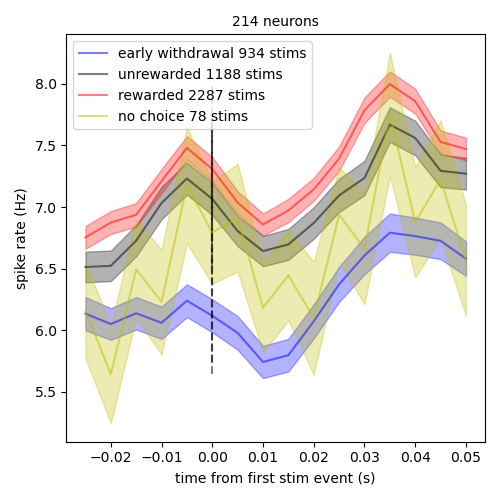

In [9]:
#loop over all outcomes, plot pop psth for those stim events, and save fig
binwidth_ms = 5
tpre = 0.025
tpost = 0.055

plt.figure(figsize=(5, 5))
for outcome, c in zip(np.unique(trial_ts.trial_outcome), ['b', 'k', 'r', 'y']):
    ts = np.hstack(trial_ts[trial_ts.trial_outcome == outcome].stim_ts)
    unit_fr = []
    with suppress_print():
        for i in range(len(single_unit_timestamps)):
            try:
                unit_fr.append(compute_firing_rate(ts, single_unit_timestamps[i], tpre, tpost, binwidth_ms, kernel=None)[0])
            except:
                unit_fr.append(np.nan)
    psth = np.mean(unit_fr, axis = 0)
    # psth, _ = compute_firing_rate(ts, population_timestamps, tpre, tpost, binwidth_ms, kernel=None)
    n_stims = len(psth)

    if outcome == 0:
        txt = 'unrewarded'
    elif outcome == 1:
        txt = 'rewarded'
    elif outcome == -1:
        txt = 'early withdrawal'
    elif outcome == 2:
        txt = 'no choice'

    plot_psth(compute_mean_sem(psth), tpre, tpost, binwidth_ms,
              xlabel = 'time from first stim event (s)',
              ylabel = 'spike rate (Hz)',
              fig_title = f"{n_units} neurons",
              data_label = f'{txt} {n_stims} stims',
              color=c)
    # filename = f"pop_stim_kernel_{rate}_Hz.png"
    # save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/stim_kernels_per_rate/')
    # filepath = os.path.join(save_dir, filename)
    # plt.savefig(filepath)
plt.legend()
del outcome, ts, psth, n_stims

Aligning activity to multiple task events

Text(0.5, 0.98, '214 units - 281 trials')

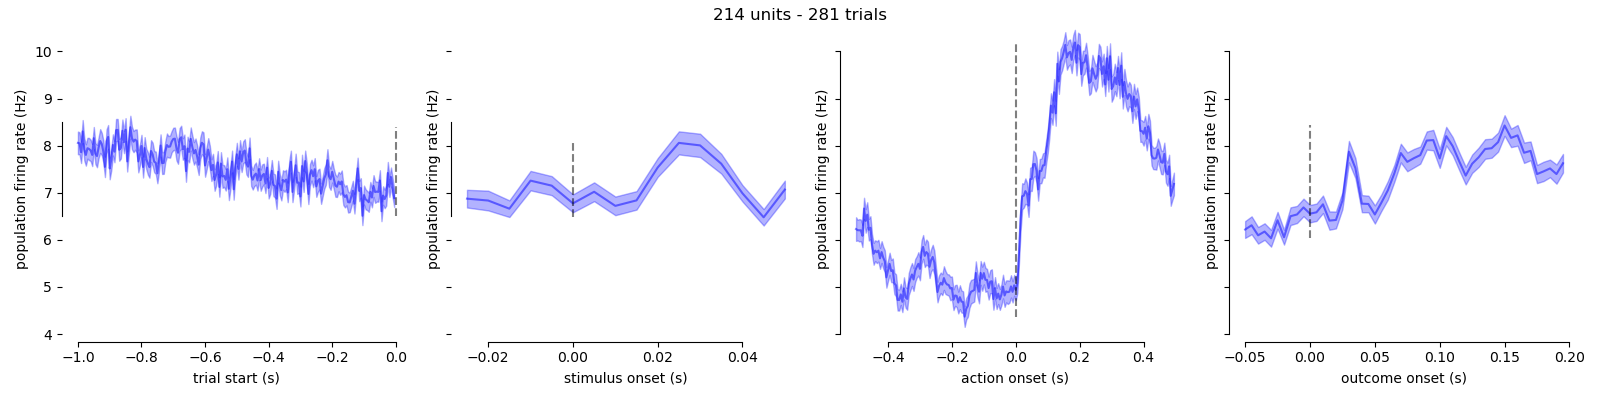

In [86]:
timepoints = dict()
initiation = []
stimulus = []
action = []
response = []

for _ , trial in trial_ts[trial_ts.trial_outcome.isin([0,1])].iterrows():
    initiation.append(trial.center_port_entries[-1])
    stimulus.append(trial.first_stim_ts)
    action.append(trial.center_port_exits[-1])
    response.append(trial.response)

timepoints = pd.DataFrame(dict({'initiation' : initiation, 'stimulus' : stimulus, 'action' : action, 'response' : response}))
n_trials = len(timepoints)
binwidth_ms = 5
# tpre = 0.025
# tpost = 0.055

# single_unit_timestamps = get_cluster_spike_times(spike_times = st, spike_clusters = sc, good_unit_ids = good_unit_ids)

#initiation
fig, axs = plt.subplots(1,4,figsize=(16, 4), sharey=True)
psth = get_population_firing_rate(event_times = timepoints.initiation,
                                  spike_times = single_unit_timestamps,
                                  tpre = 1,
                                  tpost = 0,
                                  binwidth_ms = binwidth_ms)
plot_psth(compute_mean_sem(psth), 1, 0, binwidth_ms, 'trial start (s)', 'population firing rate (Hz)', ax=axs[0])
separate_axes(axs[0])

#stimulus
psth = get_population_firing_rate(event_times = timepoints.stimulus,
                                  spike_times = single_unit_timestamps,
                                  tpre = 0.025,
                                  tpost = 0.055,
                                  binwidth_ms = 5)
plot_psth(compute_mean_sem(psth), 0.025, 0.055, 5, 'stimulus onset (s)', 'population firing rate (Hz)', ax=axs[1])
separate_axes(axs[1])

#action
psth = get_population_firing_rate(event_times = timepoints.action,
                                  spike_times = single_unit_timestamps,
                                  tpre = 0.5,
                                  tpost = 0.5,
                                  binwidth_ms = binwidth_ms)
plot_psth(compute_mean_sem(psth), 0.5, 0.5, binwidth_ms, 'action onset (s)', 'population firing rate (Hz)', ax=axs[2])
separate_axes(axs[2])

#response
psth = get_population_firing_rate(event_times = timepoints.response,
                                  spike_times = single_unit_timestamps,
                                  tpre = 0.05,
                                  tpost = 0.2,
                                  binwidth_ms = binwidth_ms)
plot_psth(compute_mean_sem(psth), 0.05, 0.2, binwidth_ms, 'outcome onset (s)', 'population firing rate (Hz)', ax=axs[3])
separate_axes(axs[3])

fig.suptitle(f"{n_units} units - {n_trials} trials")

Single neuron interactive viewer

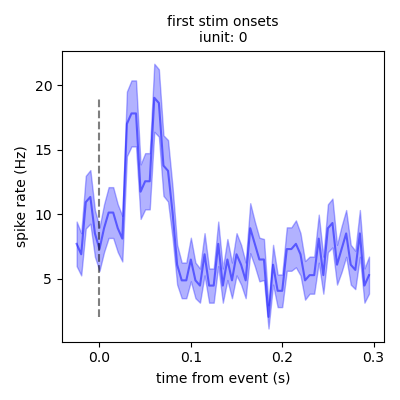

In [11]:
binwidth_ms = 5
tpre = 0.025
tpost = 0.3


plt.figure(figsize=(4, 4))
# fig, axs = plt.subplots(1,2, figsize=(6,4))
individual_psth_viewer(event_times = trial_ts.first_stim_ts, 
                       single_unit_timestamps = single_unit_timestamps, 
                       pre_seconds = tpre, 
                       post_seconds = tpost, 
                       binwidth_ms = binwidth_ms, 
                       save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/'),
                       fig_title = 'first stim onsets')

# individual_psth_viewer(event_times = trial_ts.first_stim_ts, 
#                        single_unit_timestamps = single_unit_timestamps, 
#                        pre_seconds = tpre, 
#                        post_seconds = tpost, 
#                        binwidth_ms = binwidth_ms, 
#                        save_dir = Path('/home/gabriel/lib/lab-projects/ephys/figures/'),
#                        fig_title = 'first stim onsets',
#                        ax = axs[1])